In [1]:
mathurinache_the_lj_speech_dataset_path, andreadiubaldo_wavefake_test_path = ('/home/jovyan/.cache/kagglehub/datasets/mathurinache/the-lj-speech-dataset/versions/1',
 '/home/jovyan/.cache/kagglehub/datasets/andreadiubaldo/wavefake-test/versions/1')

In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import IPython
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Reshape,MaxPooling2D, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Sequential, regularizers

# gpus = tf.config.list_physical_devices('GPU')
# gpu = gpus[0]

# tf.config.experimental.set_memory_growth(gpu, True)

2025-01-28 20:04:20.311871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-28 20:04:22.909411: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-28 20:04:22.909535: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/ext

In [4]:
import os

paths = []
labels = []

# Define the root directory
real_root_dir = mathurinache_the_lj_speech_dataset_path + "/LJSpeech-1.1/wavs" # '/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs'
fake_root_dir = andreadiubaldo_wavefake_test_path + "/generated_audio/ljspeech_melgan"  # '/kaggle/input/wavefake-test/generated_audio/ljspeech_melgan'
# Iterate through the subdirectories
for filename in os.listdir(real_root_dir):
    file_path = os.path.join(real_root_dir, filename)
    paths.append(file_path)
    # Add label based on the subdirectory name
    labels.append('real')

for filename in os.listdir(fake_root_dir):
    file_path = os.path.join(fake_root_dir, filename)
    paths.append(file_path)
    # Add label based on the subdirectory name
    labels.append('fake')

print('Dataset is loaded')


Dataset is loaded


In [5]:
import os
import numpy as np
import librosa

EXTRACT = False

def extract_features(fake_root_dir, real_root_dir, max_length=500):
    all_features = []
    labels = []
    
    print("Fakes")
    for file in os.listdir(fake_root_dir)[:]:
        file_path = os.path.join(fake_root_dir, file)
        try:
            # Load audio file
            audio, _ = librosa.load(file_path, sr=16000)
            
            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=15)
            mfccs = pad_or_trim(mfccs, max_length)
            
            # Extract Mel-Spectrogram features
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=16000, n_mels=15)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            mel_spectrogram_db = pad_or_trim(mel_spectrogram_db, max_length)

            # Extract CQT features
            cqt = librosa.cqt(y=audio, sr=16000, n_bins=15)
            cqt_magnitude = pad_or_trim(np.abs(cqt), max_length)

            # Extract CQCC features (Simulated from CQT)
            cqt_db = librosa.amplitude_to_db(cqt)
            cqcc = librosa.feature.mfcc(S=cqt_db, n_mfcc=15)
            cqcc = pad_or_trim(cqcc, max_length)
            
            # Stack features
            combined_features = np.vstack([mfccs, mel_spectrogram_db, cqt_magnitude, cqcc])
            # combined_features = mfccs
            # combined_features = np.vstack([mfccs, mel_spectrogram_db, cqt_magnitude])
            
            # Append features and labels
            all_features.append(combined_features)
            labels.append(1)  # 1 for fake
            
        except Exception as e:
            print(f"Error encountered while parsing file: {file_path}")
            continue
    np.save("fakes.npy", all_features)
    print("Reals")
    for file in os.listdir(real_root_dir)[:]:
        file_path = os.path.join(real_root_dir, file)
        try:
            # Load audio file
            audio, _ = librosa.load(file_path, sr=16000)
            
            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=15)
            mfccs = pad_or_trim(mfccs, max_length)
            
            # Extract Mel-Spectrogram features
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=16000, n_mels=15)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            mel_spectrogram_db = pad_or_trim(mel_spectrogram_db, max_length)

            # Extract CQT features
            cqt = librosa.cqt(y=audio, sr=16000, n_bins=15)
            cqt_magnitude = pad_or_trim(np.abs(cqt), max_length)

            # Extract CQCC features (Simulated from CQT)
            cqt_db = librosa.amplitude_to_db(cqt)
            cqcc = librosa.feature.mfcc(S=cqt_db, n_mfcc=15)
            cqcc = pad_or_trim(cqcc, max_length)
            
            # Stack features
            combined_features = np.vstack([mfccs, mel_spectrogram_db, cqt_magnitude, cqcc])
            # combined_features = mfccs
            # combined_features = np.vstack([mfccs, mel_spectrogram_db, cqt_magnitude])
            
            # Append features and labels
            all_features.append(combined_features)
            labels.append(0)  # 0 for real
            
        except Exception as e:
            print(f"Error encountered while parsing file: {file_path}")
            continue
    np.save("reals.npy", all_features)

    # Convert lists to NumPy arrays
    return np.array(all_features), np.array(labels)

def pad_or_trim(features, max_length):
    """
    Pads or trims the input feature array to a specific max_length.
    """
    if features.shape[1] < max_length:
        return np.pad(features, ((0, 0), (0, max_length - features.shape[1])), mode='constant')
    else:
        return features[:, :max_length]

if EXTRACT:
    x, y = extract_features(fake_root_dir, real_root_dir)
    print("Features shape:", x.shape)  # Should be (10, 40*4, 500)
    print("Labels shape:", y.shape)    # Should be (10,)

In [2]:
# np.save("x3.npy", x)
# np.save("y3.npy", y)

x = np.load('x3.npy')
y = np.load('y3.npy')

In [3]:
x.shape, y.shape

((26200, 60, 500), (26200,))

In [8]:
# new_second_dim_size = x.shape[1] // 2

print(new_second_dim_size)   /
# Halve the first dimension
# x_halved = x[:, :new_second_dim_size, :]

# del x
# del y
# del x_halved

30


In [5]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = .2)

In [6]:
xtrain.shape, xtrain[1:].shape         

((20960, 60, 500), (20959, 60, 500))

In [7]:
# strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())
strategy = tf.distribute.get_strategy()

with strategy.scope():
    # Create and compile the model inside the strategy scope
    model = Sequential([
        layers.Reshape((60, 500, 1), input_shape=xtrain.shape[1:]),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Reshape((-1, 128)),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3)),
        layers.BatchNormalization(),
        layers.Bidirectional(layers.LSTM(128, dropout=0.3)),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Print the model summary to confirm the structure
model.summary()

2025-01-28 20:19:28.415882: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-28 20:19:31.953331: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38208 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:10:1c.0, compute capability: 8.0
2025-01-28 20:19:31.956921: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38208 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:90:1c.0, compute capability: 8.0
2025-01-28 20:19:31.958527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/tas

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 60, 500, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 60, 500, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 60, 500, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 250, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 250, 64)       18496     
                                                                 
 batch_normalization_1 (Batc  (None, 30, 250, 64)      2

In [ ]:
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define EarlyStopping callback to monitor validation accuracy
early_stopping = EarlyStopping(
    monitor='val_accuracy',        # Monitor validation accuracy instead of loss
    patience=10,                     # Stop after 10 epochs of no improvement
    restore_best_weights=True,      # Restore the weights from the epoch with the best validation accuracy
    mode='max',                     # 'max' because higher accuracy is better (we want to maximize val_accuracy)
    verbose=1                       # Output when training stops early
)

batch_size = 32 * strategy.num_replicas_in_sync

# Train the model with early stopping
history = model.fit(
    xtrain, ytrain,                 # Training data
    epochs=5,                      # Max number of epochs
    batch_size=batch_size,                  # Batch size
    validation_data=(xtest, ytest),   # Validation data
    # callbacks=[early_stopping]      # Add early stopping callback
)

In [28]:
loss, accuracy = model.evaluate(xtest,ytest)
loss, accuracy

2025-01-28 16:11:19.116593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


164/164 [==============================] - 19s 25ms/step - loss: 0.0166 - accuracy: 0.9952


(0.016631802543997765, 0.9952290058135986)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 2 rows, 1 column


# First subplot (Sine Wave)
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

plt.title('Training and Validation Accuracy')

# Second subplot (Cosine Wave)
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')

ax2.legend()

# Save and show
plt.tight_layout()
plt.savefig('two_stacked_plots.png')
plt.show()


In [ ]:
cpu_model = tf.keras.models.clone_model(model)
cpu_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Copy weights from the TPU model to the CPU model
cpu_model.set_weights(model.get_weights())

# # Save only the weights of the CPU model
cpu_model.save_weights('v3_1.h5')

In [8]:
model.load_weights("v3_1.h5")

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# EER

from sklearn.metrics import roc_curve

preds = model.predict(xtest)

# Calculate the false acceptance and false rejection rates
fpr, tpr, thresholds = roc_curve(ytest, preds)

# False rejection rate is 1 - true positive rate
frr = 1 - tpr

# Find the point where FAR is closest to FRR
eer_threshold_index = np.nanargmin(np.absolute((fpr - frr)))
eer_threshold = thresholds[eer_threshold_index]
eer = fpr[eer_threshold_index]

print(f"EER: {eer:.4f} at threshold: {eer_threshold:.4f}")

2025-01-28 20:20:51.679782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204


  7/164 [>.............................] - ETA: 4s

2025-01-28 20:20:55.418160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


164/164 [==============================] - 10s 26ms/step
EER: 0.0030 at threshold: 0.5614


## Train with ASVspoof

In [47]:
import glob

# Create dataset
BASE_PATH = "/home/jovyan/.cache/kagglehub/datasets/awsaf49/asvpoof-2019-dataset/versions/1/LA/LA/ASVspoof2019_LA"


TRAIN_FILENAMES = glob.glob(BASE_PATH + '_train/flac/*.flac')
VALID_FILENAMES = glob.glob(BASE_PATH + '_eval/flac/*.flac')
TEST_FILENAMES = glob.glob(BASE_PATH + '_dev/flac/*.flac')

len(TRAIN_FILENAMES), len(VALID_FILENAMES), len(TEST_FILENAMES)

(25380, 71933, 24986)

In [3]:
BASE_PATH = "/home/jovyan/.cache/kagglehub/datasets/awsaf49/asvpoof-2019-dataset/versions/1/LA/LA/ASVspoof2019_LA"

# Train 
train_df = pd.read_csv(f'{BASE_PATH}_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt', sep=" ", header=None)
train_df.columns =['speaker_id','filename','system_id','null','class_name']
train_df.drop(columns=['null'],inplace=True)
train_df['filepath'] = f'{BASE_PATH}_train/flac/'+train_df.filename+'.flac'
train_df['target'] = (train_df.class_name=='spoof').astype('int32') # set labels 1 for fake and 0 for real

# if True:
    # train_df = train_df.sample(2500).reset_index(drop=True)

print(f'Train Samples: {len(train_df)}')
train_df.head(10)

Train Samples: 25380


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0079,LA_T_1138215,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
1,LA_0079,LA_T_1271820,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
2,LA_0079,LA_T_1272637,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
3,LA_0079,LA_T_1276960,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
4,LA_0079,LA_T_1341447,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
5,LA_0079,LA_T_1363611,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
6,LA_0079,LA_T_1596451,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
7,LA_0079,LA_T_1608170,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
8,LA_0079,LA_T_1684951,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
9,LA_0079,LA_T_1699801,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0


In [4]:
train_df['target'].value_counts()

1    22800
0     2580
Name: target, dtype: int64

In [5]:
balanced_train_df = pd.concat([
    train_df[train_df['target'] == 0],
    train_df[train_df['target'] == 1].sample(2580, random_state=42)
]).reset_index(drop=True)

In [6]:
# Test 
test_df = pd.read_csv(f'{BASE_PATH}_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt', sep=" ", header=None)
test_df.columns =['speaker_id','filename','system_id','null','class_name']
test_df.drop(columns=['null'],inplace=True)
test_df['filepath'] = f'{BASE_PATH}_dev/flac/'+test_df.filename+'.flac'
test_df['target'] = (test_df.class_name=='spoof').astype('int32') # set labels 1 for fake and 0 for real

print(f'Test Samples: {len(test_df)}')
test_df.head(10)

Test Samples: 24844


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0069,LA_D_1047731,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
1,LA_0069,LA_D_1105538,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
2,LA_0069,LA_D_1125976,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
3,LA_0069,LA_D_1293230,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
4,LA_0069,LA_D_1340209,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
5,LA_0069,LA_D_1376638,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
6,LA_0069,LA_D_1377420,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
7,LA_0069,LA_D_1403371,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
8,LA_0069,LA_D_1590530,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
9,LA_0069,LA_D_1595036,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0


In [7]:
balanced_test_df = pd.concat([
    test_df[test_df['target'] == 0],
    test_df[test_df['target'] == 1].sample(2548, random_state=42)
]).reset_index(drop=True)

In [8]:

# Validation 
val_df = pd.read_csv(f'{BASE_PATH}_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt', sep=" ", header=None)
val_df.columns =['speaker_id','filename','system_id','null','class_name']
val_df.drop(columns=['null'],inplace=True)
val_df['filepath'] = f'{BASE_PATH}_eval/flac/'+val_df.filename+'.flac'
val_df['target'] = (val_df.class_name=='spoof').astype('int32') # set labels 1 for fake and 0 for real

print(f'Test Samples: {len(test_df)}')
test_df.head(10)

Test Samples: 24844


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0069,LA_D_1047731,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
1,LA_0069,LA_D_1105538,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
2,LA_0069,LA_D_1125976,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
3,LA_0069,LA_D_1293230,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
4,LA_0069,LA_D_1340209,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
5,LA_0069,LA_D_1376638,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
6,LA_0069,LA_D_1377420,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
7,LA_0069,LA_D_1403371,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
8,LA_0069,LA_D_1590530,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0
9,LA_0069,LA_D_1595036,-,bonafide,/home/jovyan/.cache/kagglehub/datasets/awsaf49...,0


In [9]:
val_df['target'].value_counts()

1    63882
0     7355
Name: target, dtype: int64

In [10]:
balanced_val_df = pd.concat([
    val_df[val_df['target'] == 0],
    val_df[val_df['target'] == 1].sample(7355, random_state=42)
]).reset_index(drop=True)

In [11]:
balanced_df = pd.concat([balanced_train_df, balanced_test_df, balanced_val_df]) # .target.value_counts()

balanced_df.target.value_counts()

0    12483
1    12483
Name: target, dtype: int64

In [13]:
import os
import numpy as np
import librosa

EXTRACT = False

def extract_df_features(df, max_length=500):
    all_features = []
    labels = []
    
    for index, row in df.iterrows():    
        try:
            # Load audio file
            audio, _ = librosa.load(row["filepath"], sr=16000)
            
            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=15)
            mfccs = pad_or_trim(mfccs, max_length)
            
            # Extract Mel-Spectrogram features
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=16000, n_mels=15)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            mel_spectrogram_db = pad_or_trim(mel_spectrogram_db, max_length)

            # Extract CQT features
            cqt = librosa.cqt(y=audio, sr=16000, n_bins=15)
            cqt_magnitude = pad_or_trim(np.abs(cqt), max_length)

            # Extract CQCC features (Simulated from CQT)
            cqt_db = librosa.amplitude_to_db(cqt)
            cqcc = librosa.feature.mfcc(S=cqt_db, n_mfcc=15)
            cqcc = pad_or_trim(cqcc, max_length)
            
            # Stack features
            combined_features = np.vstack([mfccs, mel_spectrogram_db, cqt_magnitude, cqcc])
            # combined_features = mfccs
            # combined_features = np.vstack([mfccs, mel_spectrogram_db, cqt_magnitude])
            
            # Append features and labels
            all_features.append(combined_features)
            labels.append(row.target)  # 1 for fake
            
        except Exception as e:
            print(e)
            print(f"Error encountered while parsing file: {row.filepath}")
            
    print("Saving features")
    np.save("asv_full.npy", all_features)

    # Convert lists to NumPy arrays
    return np.array(all_features), np.array(labels)

def pad_or_trim(features, max_length):
    """
    Pads or trims the input feature array to a specific max_length.
    """
    if features.shape[1] < max_length:
        return np.pad(features, ((0, 0), (0, max_length - features.shape[1])), mode='constant')
    else:
        return features[:, :max_length]


if EXTRACT:
    x, y = extract_df_features(balanced_df)
    print("Features shape:", x.shape)  # Should be (10, 40*4, 500)
    print("Labels shape:", y.shape)    # Should be (10,)

Saving features
Labels shape: (24966,)


In [13]:
# np.save("x2.npy", x)
# np.save("asv_labels.npy", y)

x = np.load('asv_full.npy')
y = np.load('asv_labels.npy')

In [14]:
x.shape, y.shape

((24966, 60, 500), (24966,))

In [15]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = .2)

In [11]:
# strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())
# strategy = tf.distribute.MirroredStrategy()
strategy = tf.distribute.get_strategy()

with strategy.scope():
    # Create and compile the model inside the strategy scope
    model_asv = Sequential([
        layers.Reshape((60, 500, 1), input_shape=xtrain.shape[1:]),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Reshape((-1, 128)),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3)),
        layers.BatchNormalization(),
        layers.Bidirectional(layers.LSTM(128, dropout=0.3)),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model_asv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Print the model summary to confirm the structure
model_asv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 60, 500, 1)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 500, 32)       320       
                                                                 
 batch_normalization_5 (Batc  (None, 60, 500, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 250, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 250, 64)       18496     
                                                                 
 batch_normalization_6 (Batc  (None, 30, 250, 64)     

In [10]:
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define EarlyStopping callback to monitor validation accuracy
early_stopping = EarlyStopping(
    monitor='val_accuracy',        # Monitor validation accuracy instead of loss
    patience=10,                     # Stop after 10 epochs of no improvement
    restore_best_weights=True,      # Restore the weights from the epoch with the best validation accuracy
    mode='max',                     # 'max' because higher accuracy is better (we want to maximize val_accuracy)
    verbose=1                       # Output when training stops early
)

batch_size = 32 * strategy.num_replicas_in_sync

# Train the model with early stopping
history_asv = model_asv.fit(
    xtrain, ytrain,
    epochs=50,
    batch_size=batch_size,
    validation_data=(xtest, ytest),
    # callbacks=[early_stopping]      # Add early stopping callback
)

Epoch 1/50
625/625 [==============================] - 55s 73ms/step - loss: 0.4674 - accuracy: 0.8620 - val_loss: 0.3436 - val_accuracy: 0.9075
Epoch 2/50
625/625 [==============================] - 44s 70ms/step - loss: 0.3056 - accuracy: 0.9076 - val_loss: 0.3023 - val_accuracy: 0.8959
Epoch 3/50
625/625 [==============================] - 46s 74ms/step - loss: 0.2163 - accuracy: 0.9306 - val_loss: 0.2940 - val_accuracy: 0.9187
Epoch 4/50
625/625 [==============================] - 60s 96ms/step - loss: 0.1628 - accuracy: 0.9502 - val_loss: 0.1348 - val_accuracy: 0.9543
Epoch 5/50
625/625 [==============================] - 54s 87ms/step - loss: 0.1343 - accuracy: 0.9582 - val_loss: 0.2182 - val_accuracy: 0.9441
Epoch 6/50
625/625 [==============================] - 53s 86ms/step - loss: 0.1156 - accuracy: 0.9630 - val_loss: 0.0921 - val_accuracy: 0.9724
Epoch 7/50
625/625 [==============================] - 54s 86ms/step - loss: 0.0994 - accuracy: 0.9682 - val_loss: 0.1065 - val_accuracy:

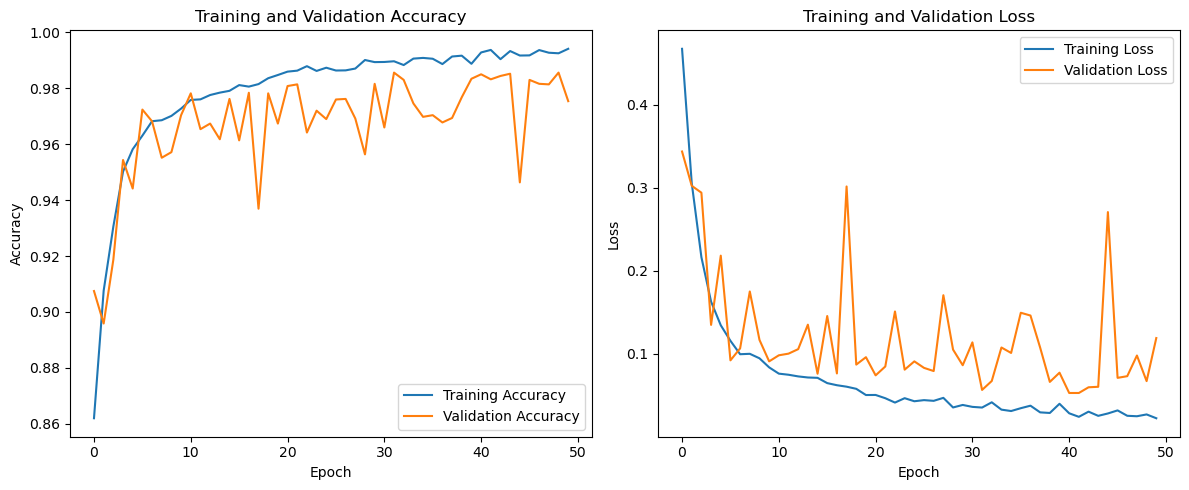

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 2 rows, 1 column


# First subplot (Sine Wave)
ax1.plot(history_asv.history['accuracy'], label='Training Accuracy')
ax1.plot(history_asv.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

plt.title('Training and Validation Accuracy')

# Second subplot (Cosine Wave)
ax2.plot(history_asv.history['loss'], label='Training Loss')
ax2.plot(history_asv.history['val_loss'], label='Validation Loss')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')

ax2.legend()

# Save and show
plt.tight_layout()
plt.savefig('two_stacked_plots_asv.png')
plt.show()

In [12]:
cpu_model_asv = tf.keras.models.clone_model(model_asv)
cpu_model_asv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Copy weights from the TPU model to the CPU model
cpu_model_asv.set_weights(model_asv.get_weights())

# # Save only the weights of the CPU model
cpu_model_asv.save_weights('asv_2.h5')

In [14]:
# EER
import numpy as np
from sklearn.metrics import roc_curve

preds = model_asv.predict(xtest)

# Calculate the false acceptance and false rejection rates
fpr, tpr, thresholds = roc_curve(ytest, preds)

# False rejection rate is 1 - true positive rate
frr = 1 - tpr

# Find the point where FAR is closest to FRR
eer_threshold_index = np.nanargmin(np.absolute((fpr - frr)))
eer_threshold = thresholds[eer_threshold_index]
eer = fpr[eer_threshold_index]

print(f"EER: {eer:.4f} at threshold: {eer_threshold:.4f}")

157/157 [==============================] - 4s 24ms/step
EER: 0.0160 at threshold: 0.0036


In [12]:
model_asv.load_weights("asv_2.h5")

model_asv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
loss, accuracy = model_asv.evaluate(xtest,ytest)
loss, accuracy

157/157 [==============================] - 6s 24ms/step - loss: 0.0457 - accuracy: 0.9888


(0.045659828931093216, 0.988786518573761)